In [16]:
# Function to create mel spectrogram dataset
def preprocess_melspec_audio_datasets(train_ds, val_ds, test_ds):
    def get_mel_spectrogram(waveform, sample_rate=SAMPLE_RATE, n_mels=128):
        stft = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(stft)
        mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=n_mels,
            num_spectrogram_bins=spectrogram.shape[-1],
            sample_rate=sample_rate
        )
        mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
        mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
        mel_spectrogram = tf.reshape(mel_spectrogram, (-1, 124, 128, 1))

        return mel_spectrogram

    def make_mel_spec_ds(ds):
        return ds.map(lambda x, y: (get_mel_spectrogram(x), y), tf.data.AUTOTUNE)

    train_mel_spec_ds = make_mel_spec_ds(train_ds)
    val_mel_spec_ds = make_mel_spec_ds(val_ds)
    test_mel_spec_ds = make_mel_spec_ds(test_ds)

    train_mel_spec_ds = train_mel_spec_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
    val_mel_spec_ds = val_mel_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_mel_spec_ds = test_mel_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

    return train_mel_spec_ds, val_mel_spec_ds, test_mel_spec_ds

In [17]:
train_mel_spec_ds, val_mel_spec_ds, test_mel_spec_ds = preprocess_melspec_audio_datasets(train_ds, val_ds, test_ds)

## Shape consistency

In [18]:
print(train_mel_spec_ds.element_spec)
print(val_mel_spec_ds.element_spec)
print(test_mel_spec_ds.element_spec)

(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 124, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


# Model 1

### Input shape 

In [19]:
example_spectrograms = next(iter(train_mel_spec_ds))[0]
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

num_labels = len(label_names)
print(f'Labels {label_names}')

Input shape: (124, 128, 1)
Labels ['ddyo' 'emabega' 'kkono' 'mumaaso' 'yimirira']


In [20]:
# Model artitecture 1
def model(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation='softmax')
    ])

    return model

model = model(input_shape, num_labels)

### Model Architecture

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,309 (446.52 KB)

 Trainable params: 114,309 (446.52 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and Train the model

In [22]:
Epochs = 50
patience = 10
learning_rate = 0.001
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


# Function to compile and train the model
def compile_and_train_model(model, train_ds, val_ds, learning_rate=learning_rate):
    try:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_lr=1e-6)
        history = model.fit(train_ds, validation_data=val_ds, epochs=Epochs, callbacks=[early_stopping, reduce_lr])
        return history
    except Exception as e:
        print(f"An error occurred during model compilation and training: {str(e)}")


In [23]:
history = compile_and_train_model(model, train_mel_spec_ds, val_mel_spec_ds)

Epoch 1/50


305/305 ━━━━━━━━━━━━━━━━━━━━ 97s 308ms/step - accuracy: 0.2451 - loss: 1.6358 - val_accuracy: 0.5218 - val_loss: 1.2658 - learning_rate: 0.0010
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 81s 265ms/step - accuracy: 0.5225 - loss: 1.1975 - val_accuracy: 0.7264 - val_loss: 0.7574 - learning_rate: 0.0010
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 80s 263ms/step - accuracy: 0.7066 - loss: 0.8028 - val_accuracy: 0.7835 - val_loss: 0.6116 - learning_rate: 0.0010
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 81s 265ms/step - accuracy: 0.7651 - loss: 0.6607 - val_accuracy: 0.8007 - val_loss: 0.5450 - learning_rate: 0.0010
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 83s 271ms/step - accuracy: 0.7921 - loss: 0.5795 - val_accuracy: 0.8048 - val_loss: 0.5198 - learning_rate: 0.0010
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 75s 247ms/step - accuracy: 0.8100 - loss: 0.5402 - val_accuracy: 0.8348 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 77s 252ms/step - accuracy: 0.8344 - loss:

### Plot Accuracy and Loss

In [24]:

# Function to plot the training history
def plot_training_history(history):
    try:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred during plotting the training history: {str(e)}")

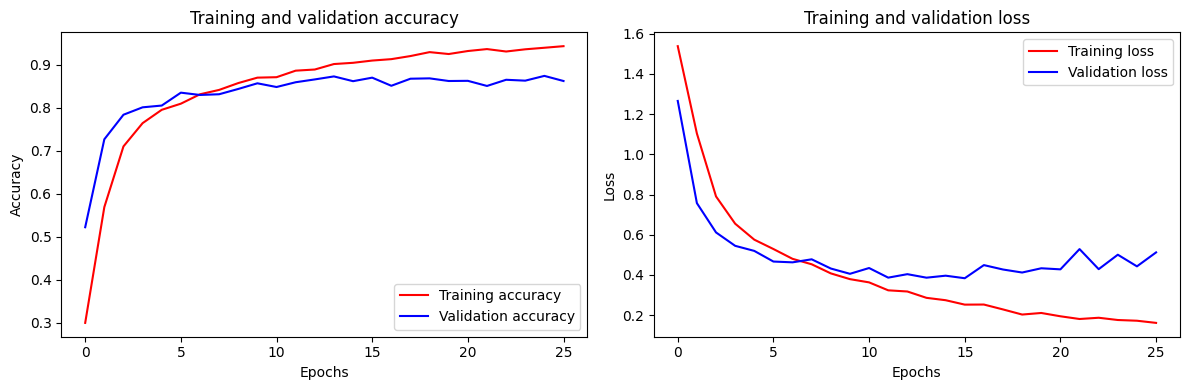

In [25]:
plot_training_history(history)

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
# Function to evaluate the model on the test dataset
def evaluate_model(model, test_ds):
    try:
        y_true = []
        y_pred = []
        for audio, labels in test_ds:
            predictions = model.predict(audio, verbose=0)
            y_true.extend(labels.numpy())
            y_pred.extend(tf.argmax(predictions, axis=1).numpy())

        loss, accuracy = model.evaluate(test_ds, verbose=0)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        print(f"Test accuracy:      {int(accuracy * 100)}%")
        print(f"Test loss:          {loss}")
        print(f"Precision:          {precision}")
        print(f"Recall:             {recall}")
        print(f"F1-score:           {f1}")
    except Exception as e:
        print(f"An error occurred during model evaluation: {str(e)}") 

In [27]:
evaluate_model(model, test_mel_spec_ds)

Test accuracy:      89%
Test loss:          0.3337378203868866
Precision:          0.8992063329289255
Recall:             0.8973333333333333
F1-score:           0.8971906076414748


## Confusion matrix

In [28]:
y_pred = model.predict(test_mel_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_mel_spec_ds.map(lambda s,lab: lab)), axis=0)
label_names_slice = ['ddyo', 'emabega', 'kkono', 'mumaaso', 'yimirira'] 

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step


In [29]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_names):
    try:
        confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mtx,
                    xticklabels=label_names,
                    yticklabels=label_names,
                    annot=True, fmt='g')
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"An error occurred during plotting the confusion matrix: {str(e)}")

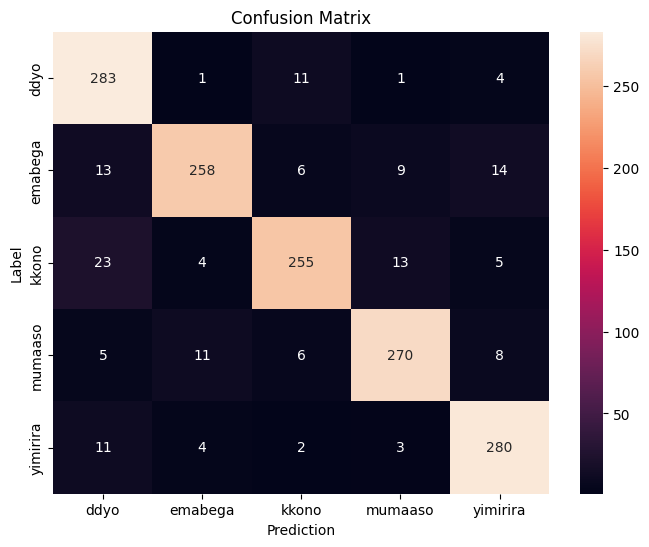

In [30]:
plot_confusion_matrix(y_true, y_pred, label_names_slice)

## save the Keras model

In [31]:
KERAS_MODEL_PATH = "model/spec_model_np_2.keras"

In [32]:
model.save(KERAS_MODEL_PATH)

## Size of the keras model

In [33]:
# Function to get the file size
def get_and_convert_file_size(file_path, unit=None):
    size = os.path.getsize(file_path)
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [34]:
keras_model_size = get_and_convert_file_size(KERAS_MODEL_PATH, 'MB')

File size: 1.352 Megabytes


## TFLite Model for model

In [35]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model/spec_model_np_2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7lsqwdl5/assets


INFO:tensorflow:Assets written to: /tmp/tmp7lsqwdl5/assets


: 

In [ ]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model/spec_model_np_2.tflite')
interpreter.allocate_tensors()

In [ ]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 128   1]


In [ ]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 5]


In [ ]:
# Prepare the test dataset 
test_mel_spec_ds = test_mel_spec_ds.unbatch().batch(1)

In [ ]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for mel_spectrogram, label in test_mel_spec_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 90%


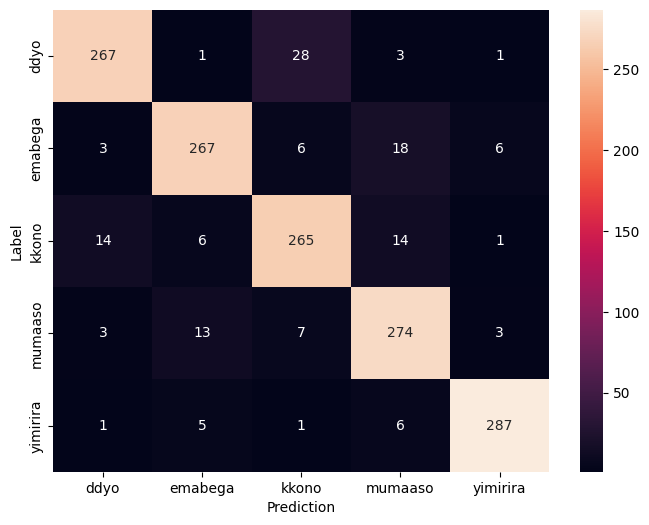

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
get_and_convert_file_size('model/spec_model_np_2.tflite', "KB")

File size: 450.992 Kilobytes


## Quntized model

In [ ]:
# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model/Quantized_spec_model_np_2.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmplvg95n78\assets


INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmplvg95n78\assets


In [ ]:
get_and_convert_file_size('model/Quantized_spec_model_np_2.tflite', "KB")

File size: 122.258 Kilobytes


In [ ]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for mel_spectrogram, label in test_mel_spec_ds:
    interpreter.set_tensor(input_details[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.9066666666666666


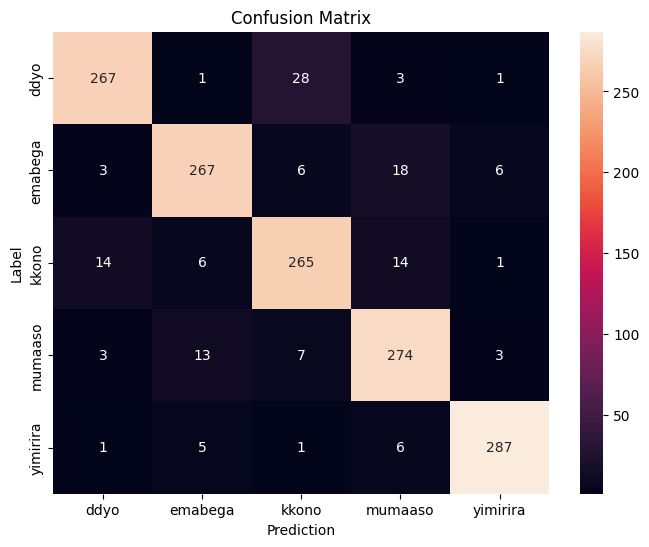

In [ ]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for mel_spectrogram, label in test_mel_spec_ds:
    interpreter.set_tensor(input_details[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 90%


# Inference

## Loading the model

In [ ]:
try:
    model = tf.keras.models.load_model('model/spec_model_np_2.keras')
    print("Model loaded successfully.")
except Exception as e:
    print("Error loading model: ", e)

Model loaded successfully.


## Record and return audio file

In [ ]:
def record_audio(filename, duration, rate=16000, channels=1, chunk_size=1024):
    p = pyaudio.PyAudio()

    # open stream
    stream = p.open(format=pyaudio.paInt16,
                    channels=channels,
                    rate=rate,
                    input=True,
                    frames_per_buffer=chunk_size)

    print("Recording...")
    frames = []

    # record for duration
    for i in range(0, int(rate / chunk_size * duration)):
        data = stream.read(chunk_size)
        frames.append(data)

    print("Finished recording.")

    # stop and close stream
    stream.stop_stream()
    stream.close()

    # terminate pyaudio object
    p.terminate()

    # save audio file
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
    wf.setframerate(rate)
    wf.writeframes(b''.join(frames))
    wf.close()

    return filename

In [ ]:
# Function to print audio properties
def print_audio_properties(file_path):
    if not os.path.isfile(file_path):
        print(f"File {file_path} does not exist.")
        return

    try:
        audio_signal, sample_rate = librosa.load(file_path, sr=None)
        with wave.open(file_path, 'rb') as audio:
            num_channels = audio.getnchannels()
            frame_rate = audio.getframerate()
            num_frames = audio.getnframes()
            duration = num_frames / float(frame_rate)

            print(f"\nAudio Properties for {os.path.basename(file_path)}")
            print(f"Number of channels:  {num_channels}")
            print(f"Sample rate (Hz):    {sample_rate}")
            print(f"Number of frames:    {num_frames}")
            print(f"Duration (s):        {duration}")
            print()
        
        # Play the audio files
        audio = Audio(file_path)
        display(audio)
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
    return

In [ ]:
# Record
audio_file = record_audio('output.wav', 2)

Recording...
Finished recording.


In [ ]:
# Print audio properties
print_audio_properties(audio_file)


Audio Properties for output.wav
Number of channels:  1
Sample rate (Hz):    16000
Number of frames:    31744
Duration (s):        1.984



## Feactures

In [ ]:
FRAME_LENGTH = 255
FRAME_STEP = 128
N_MELS = 128

In [ ]:
def get_mel_spectrogram(waveform, sample_rate=SAMPLE_RATE, n_mels=N_MELS):
    stft = tf.signal.stft(waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectrogram = tf.abs(stft)
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=sample_rate
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mel_spectrogram = tf.reshape(mel_spectrogram, (-1, 124, 128, 1))

    return mel_spectrogram

## Labels

In [ ]:
# Function to get the labels
def get_label_names():
    label_names = ['ddyo', 'emabega', 'kkono', 'mumaaso', 'yimirira'] 
    return label_names

## Prediction

In [ ]:
def predict_audio(file_path, model, sample_rate):
    x = tf.io.read_file(str(file_path))
    x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_mel_spectrogram(x, sample_rate)

    max_frames = 124
    pad_size = max_frames - x.shape[1]
    if pad_size > 0:
        x = tf.pad(x, [[0, 0], [0, pad_size], [0, 0], [0, 0]])
    else:
        x = x[:, :max_frames, :, :]

    predictions = model.predict(x)
    predicted_label_index = tf.argmax(predictions[0])
    label_names = get_label_names()
    predicted_label = label_names[predicted_label_index]

    return predicted_label, tf.nn.softmax(predictions[0])[predicted_label_index]

In [ ]:
predicted_label, probability = predict_audio(audio_file, model, SAMPLE_RATE)
print(f"Predicted label: {predicted_label}, Probability: {probability}")

1/1 [==============================] - 0s 116ms/step
Predicted label: yimirira, Probability: 0.2460210770368576
